<a href="https://colab.research.google.com/github/mritogether/ESMRMB2024_Hardware_to_Map/blob/main/02_sequence_design_for_mapping/notebooks/s10_from_1d_se_to_3d_se_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From 1D SE to 3D SE (solution)   
Now, we extend the 1D SE sequence to 3D SE sequence.   
**Exercise**           
If you have no clue, search "hint" for hints.
1. Introduce phase encoding to extend the 1D SE to 2D SE. Hint: use the pp.scale_grad(gp, -1) function to reverse the gradient polarity.
2. Introduce partition encoding to extend the 2D SE to 3D SE. Hint: use the pp.scale_grad(gs, -1) function to reverse the gradient polarity.
3. (Optional) Introduce a dummy scan (i.e. plays out multiple cycles of the sequence without recording a signal) to establish (near) steady-state magnetisation in the 3D SE sequence prior to the beginning of the ADC recording.

In [1]:
#@title 3D SE - environment setup (just need to run it once)
!pip show pypulseq || pip install pypulseq &> /dev/null
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pypulseq as pp
# for simulation
!pip show MRzeroCore || pip install MRzeroCore
import MRzeroCore as mr0
import torch
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

/usr/local/lib/python3.10/dist-packages/sigpy/config.py:15: UserWarning: Importing cupy failed. For more details, see the error stack below:

Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

  warnings.warn(


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.5/454.5 kB 19.1 MB/s eta 0:00:00


TR fill: 276.52000000000004 ms
Timing check passed successfully


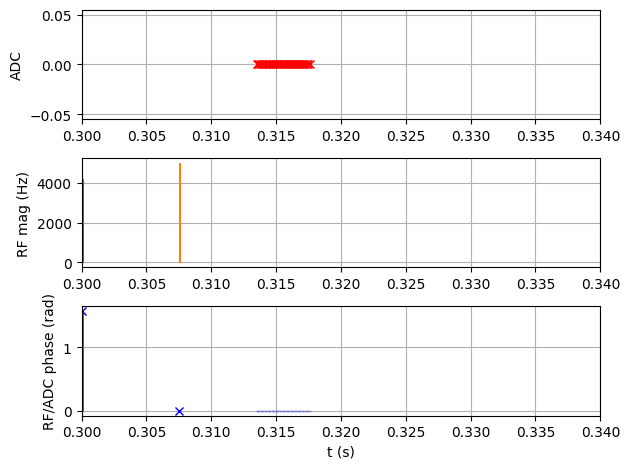

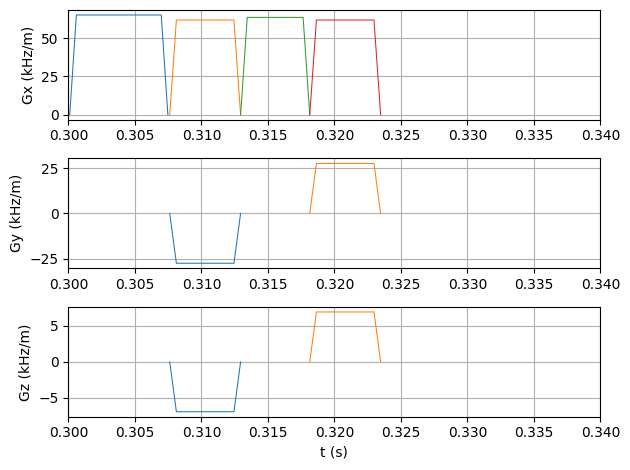

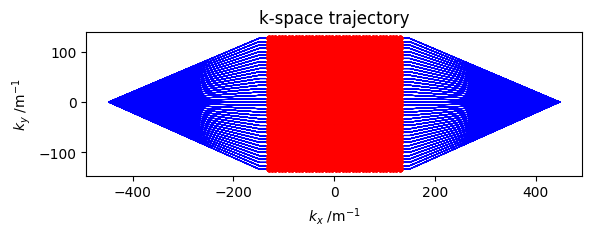

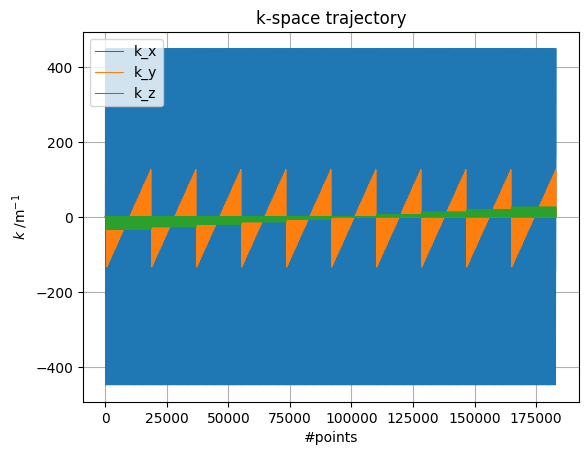

'5a8abd541949e2c7d53dd6070ac33ff2'

In [2]:
#@title 3D SE - sequence
experiment_id = 's10_3d_se'
# %% SETUP system
# choose the scanner limits
system = pp.Opts(
        max_grad=25,       # MaRCoS's limits are 25, 40 and 35 mT/m for X, Y and Z axes
        grad_unit="mT/m",
        max_slew=50,       # MaRCoS's limits are 50, 80 and 70 mT/m/ms for X, Y and Z, respectively
        slew_unit="T/m/s",
        rf_ringdown_time=15e-6,
        rf_dead_time=15e-6,
        adc_dead_time=0e-6 )
# Create a new sequence object
seq = pp.Sequence(system)

# %% DEFINE the sequence, FOV, resolution, and other parameters
fov_mm = (150, 150, 150) # Define FOV in [mm]
nRD, nPH, n3D = [40, 40, 10]     # Define resolution (matrix sizes)
TE = 15e-3 # Echo time
TR = 300e-3  # Repetition time

dG = 500e-6 # ramping time for all gradients
sampling_time = 4.2e-3
t_ex  = 60e-6 # [s], duration of the excitation pulse.
t_ref = 100e-6 # [s], duration of the refocusing pulse
fsp_r = 1 # spoiler area in the read direction in parts of the read gradient area
rf_ex_phase = np.pi / 2 # phase of the excitation pulse
rf_ref_phase = 0 # phase of the refocusing pulse

# derived and modifed parameters
fov = np.array(fov_mm) * 1e-3 # FOV in meters
TE = round(TE/system.grad_raster_time/2) * system.grad_raster_time * 2 # TE (=ESP) should be divisible to a double gradient raster, which simplifies calcuations
rf_add = math.ceil(max(system.rf_dead_time,system.rf_ringdown_time)/system.grad_raster_time)*system.grad_raster_time # round up dead times to the gradient raster time to enable correct TE & ESP calculation
t_sp = round((0.5 * (TE - sampling_time - t_ref) - rf_add)/system.grad_raster_time)*system.grad_raster_time # the duration of gradient spoiler after the refocusing pulse
t_spex = round((0.5 * (TE - t_ex - t_ref) - 2*rf_add)/system.grad_raster_time)*system.grad_raster_time # the duration of readout prephaser after the excitation pulse. note: exclude the RF ringdown time of excitation pulse and rf dead time of refocusing pulse

# ======
# CREATE EVENTS
# ======
# excitation and refocusing pulses
flip_ex = 90 * np.pi / 180
rf_ex = pp.make_block_pulse(
    flip_angle=flip_ex,
    system=system,
    duration=t_ex,
    delay=rf_add,
    phase_offset=rf_ex_phase )

d_ex=pp.make_delay(t_ex+rf_add*2)

flip_ref = 180 * np.pi / 180
rf_ref = pp.make_block_pulse(
    flip_angle=flip_ref,
    system=system,
    duration=t_ref,
    delay=rf_add,
    phase_offset=rf_ref_phase,
    use="refocusing" )

d_ref=pp.make_delay(t_ref+rf_add*2)

delta_kx = 1 / fov[0]
rd_amp = nRD * delta_kx / sampling_time

gr_acq = pp.make_trapezoid(
    channel="x",
    system=system,
    amplitude = rd_amp,
    flat_time=sampling_time,
    delay=0,
    rise_time=dG )

adc = pp.make_adc(
    num_samples=nRD,
    dwell=sampling_time/nRD,
    delay=gr_acq.rise_time )

# Readout spoiler gradient
gr_spr = pp.make_trapezoid(
    channel="x",
    system=system,
    area=gr_acq.area * fsp_r,
    duration=t_sp,
    rise_time=dG )

# hint: Phase-encoding
delta_ky = 1 / fov[1]
gp_max = pp.make_trapezoid(
                channel="y",
                system=system,
                area=delta_ky*nPH/2,
                duration=t_sp,
                rise_time=dG )

# hint: Partition encoding
delta_kz = 1 / fov[2]
gs_max = pp.make_trapezoid(
                channel="z",
                system=system,
                area=delta_kz*n3D/2,
                duration=t_sp,
                rise_time=dG )

# readout prephaser: account for readout pre-spoiler and readout gradient
agr_preph = gr_acq.area / 2 + gr_spr.area
gr_preph = pp.make_trapezoid(
    channel="x", system=system, area=agr_preph, duration=t_spex, rise_time=dG )

# Fill-times
t_ex = pp.calc_duration(d_ex) + pp.calc_duration(gr_preph)
t_ref = pp.calc_duration(d_ref) + pp.calc_duration(gr_acq) + 2 * pp.calc_duration(gr_spr)

TR_fill = TR - t_ex - t_ref
# Round to gradient raster
TR_fill = system.grad_raster_time * np.round(TR_fill / system.grad_raster_time)
if TR_fill < 0:
    TR_fill = 1e-3
    warnings.warn(
        f"TR too short, adapted to: {1000 * (t_ex + t_ref + TR_fill)} ms"
    )
else:
    print(f"TR fill: {1000 * TR_fill} ms")
delay_TR = pp.make_delay(TR_fill)

# ======
# CONSTRUCT SEQUENCE
# ======
for Cz in range(-1,n3D): # partition encoding loop, -1 for dummy scan
    if Cz >= 0:
        sl_scale = (Cz-n3D/2)/n3D*2; # from -1 to +1
        nPH_range=range(nPH)
    else:
        sl_scale = 0.0
        nPH_range=range(1) # skip the nPH loop for dummy scan(s)

    gs=pp.scale_grad(gs_max, sl_scale)

    for Cy in nPH_range: # phase encoding loop
        seq.add_block(rf_ex, d_ex)
        seq.add_block(gr_preph)

        if Cz >= 0:
            pe_scale = (Cy-nPH/2)/nPH*2; # from -1 to 1
        else:
            pe_scale = 0.0

        gp=pp.scale_grad(gp_max, pe_scale)

        seq.add_block(rf_ref, d_ref)
        if Cz >= 0:
            seq.add_block(gs, gp, gr_spr)
            seq.add_block(gr_acq, adc)
            seq.add_block(pp.scale_grad(gs, -1), pp.scale_grad(gp, -1), gr_spr)
        else:
            seq.add_block(gs, gp, gr_spr)
            seq.add_block(gr_acq)
            seq.add_block(pp.scale_grad(gs, -1), pp.scale_grad(gp, -1), gr_spr)

        seq.add_block(delay_TR)

(ok, error_report) = seq.check_timing()  # Check whether the timing of the sequence is correct
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

# ======
# VISUALIZATION
# ======
seq.plot(time_range=(TR, TR+0.04))

# Plot k-space trajectory
k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()

plt.figure()
plt.plot(k_traj[0],k_traj[1], 'b-')
plt.plot(k_traj_adc[0],k_traj_adc[1],'r.')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.title('k-space trajectory')
plt.xlabel(r'$k_x \mathregular{\ /m^{-1}}$')
plt.ylabel(r'$k_y \mathregular{\ /m^{-1}}$')
plt.show()

plt.figure()
p1 = plt.plot(k_traj[0], label='k_x')
p2 = plt.plot(k_traj[1], label='k_y')
p3 = plt.plot(k_traj[2], label='k_z')
plt.legend(loc="upper left")
plt.xlabel('#points')
plt.ylabel('$k \mathregular{\ /m^{-1}}$')
ax = plt.gca()
ax.grid();
plt.title('k-space trajectory')
plt.show()

# Prepare the sequence output for the scanner
seq.set_definition('Name', experiment_id)
seq.write(experiment_id+'.seq')

VoxelGridPhantom
size = tensor([0.1500, 0.1500, 0.1500])


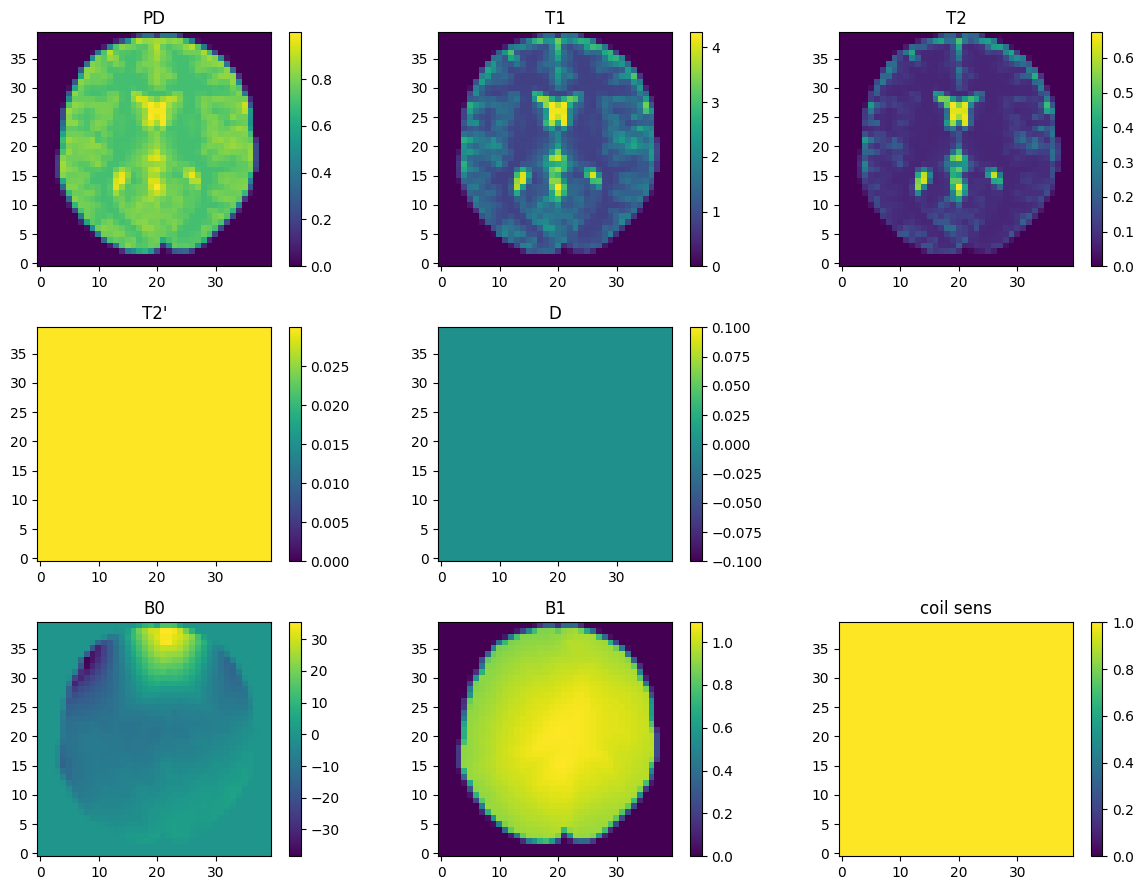

In [3]:
#@title 3D SE in a 2D brain phantom - simulation
dB0 = 0
sz = [nRD, nPH, 1]
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
# (i) load a phantom object from file
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], sz[2])
# The default fov is loaded from the data, but we can change it:
obj_p.size = torch.tensor([0.15,0.15,0.15])
# Manipulate loaded data
obj_p.T2dash[:] = 30e-3
obj_p.D *= 0
obj_p.B0 *= 1    # alter the B0 inhomogeneity
# Store PD and B0 for comparison
PD = obj_p.PD
B0 = obj_p.B0
# Manipulate loaded data
obj_p.B0+=dB0
obj_p.D*=0
obj_p.plot()
# Convert Phantom into simulation data
obj_p=obj_p.build()

# %% SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.import_file(experiment_id + '.seq')
# Simulate the sequence
graph=mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal=mr0.execute_graph(graph, seq0, obj_p, print_progress=False)
# PLOT sequence with signal in the ADC subplot
# seq.plot(plot_now=False)
# mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
# plt.show()


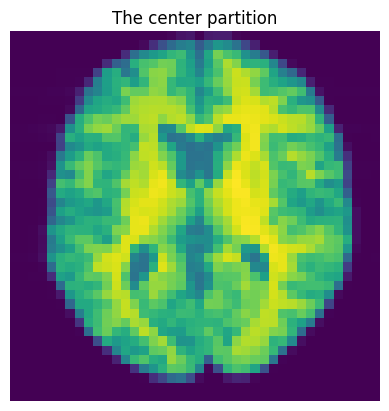

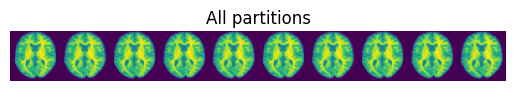

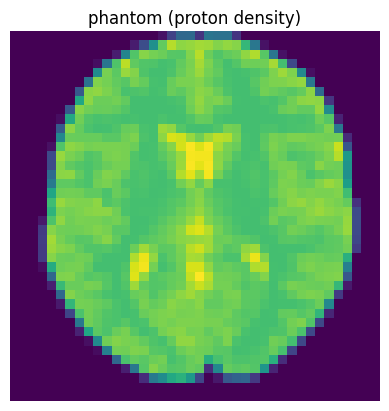

In [4]:
#@title 3D SE - reconstruction
# 3D FFT
def fft_3d(x):
    return np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x, axes=(0, 1, 2)), axes=(0, 1, 2)), axes=(0, 1, 2))

kspace = np.reshape(signal, (n3D, nPH, nRD))
im = fft_3d(kspace)

partition = 5 ; # The center partition
plt.figure()
plt.title('The center partition')
plt.imshow(np.abs(im[partition,:,:].squeeze().reshape(nPH,nRD)), origin="lower"); plt.axis('off');

plt.figure()
plt.title('All partitions')
plt.imshow(np.abs(im.transpose([1,0,2]).reshape(nPH,nRD*n3D)), origin="lower"); plt.axis('off');


plt.figure()
plt.title('phantom (proton density)')
plt.imshow(PD.squeeze().T, origin="lower"); plt.axis('off');